# Understanding Volatility Movements  

## Introduction

For our next application of neural networks, some extra background  about derivatives is required.  The Black−Scholes−Merton model relates an option price to the asset price, strike price, dividend yield, riskfree interest rate, time to maturity, and volatility. All of these quantities  are known by analysts except volatility. This means that the Black−Scholes−Merton model in effect provides a one-to-one mapping  of volatility to the price of an option. The volatility that gives the market  price of an option is known as the implied volatility. The moneyness of an option is a measure of how likely an option is to  be exercised. One measure of the moneyness of an option that is frequently used by traders is delta. This is the sensitivity of the option’s  price to the price of the underlying asset. For the Black−Scholes−Merton  model given earlier, the delta of a call option is $𝑒^{−𝑞𝑇𝑁(𝑑_1)}$. For a call  option that is highly unlikely to be exercised (high strike price), delta is  close to zero. As the option become more likely to be exercised (i.e., the  strike price is reduced), delta increases. When the option is almost certain to be exercised delta is close to one.  The volatility surface gives the implied volatility as a function of the  moneyness and time to maturity. If Black−Scholes−Merton was a perfect model for the pricing of options in the market, the implied volatilities for all options would be the same and would never change. In practice, the model is far from perfect and the volatility surface is used by  analysts to monitor the market.  

Many different non-linear  shapes for the surface are observed in practice. When the price of an  asset declines, all implied volatilities calculated from options on the asset tend to increase, and vice versa. However, the implied volatilities do  not all change by the same amount. This leads to many variations in the  pattern of implied volatilities.  Understanding how the volatility surface moves is important for a  number of reasons:

- It can help a trader hedge exposures more precisely 

- It can help a quant determine a more sophisticated model reflecting how options are priced by the market.  

- It can help a trader adjust implied volatilities in a market where  asset prices are changing fast. 

A neural network is a natural tool for using empirical data to model volatility surface movements. We will illustrate how it can be used in what  follows. 

In [1]:
#This program takes about 60 minutes to run
#Loading Package
import os

import time
import numpy as np
import scipy as sci
import scipy.io as sio
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras


from numpy.random import seed
seed(100)


import matplotlib.pyplot as plt
from IPython.display import clear_output


## The Dataset

Our data consists of call options on the S&P 500 between 2014 and  2019.

In [2]:
# load raw data
DATA_FOLDER = './data'
raw = pd.read_csv(os.path.join(DATA_FOLDER, 'Implied_Volatility_Data_vFinal.csv'))
# check the raw data
print("Size of the dataset (row, col): ", raw.shape)
raw.head(n=5)

FileNotFoundError: [Errno 2] No such file or directory: './data\\Implied_Volatility_Data_vFinal.csv'

## Construct the 3 variables for Regression Approach

There are  three features:  

- The return on the S&P 500 from one day to the next (i.e., increase in S&P 500 divided by its level)  

- The time to maturity  

- The delta of the option  The target is the change in the implied volatility. 

The objective is to  minimize the mean squared error between the predicted change in the  implied volatility and the actual change.

In constructing a machine learning model, it is always useful to have  a simpler model as a benchmark. For this application, we can use the  following model:  

$$\text{Expected change in implied volatility} = R \frac{a+b\Delta + c \Delta^2}{\sqrt{T}}$$

where $R$ is the return on the asset (= change in price divided by initial  price), $T$ is the option’s time to maturity, $\Delta$ is the delta measure of the  option’s moneyness, and $a$, $b$, and $c$ are constants. This model was suggested by Hull and White (2017) and is quite popular with practitioner. The $a$, $b$, and $c$ can be estimated by regressing implied volatility  changes against $R/\sqrt{𝑇}$, $R\Delta/\sqrt{T}$, and $R\Delta^2/\sqrt{T}$.  

In [3]:
# construct the 3 variables for regression
raw['x1'] = raw['SPX Return'] / np.sqrt(raw['Time to Maturity in Year'])
raw['x2'] = raw['SPX Return'] / np.sqrt(raw['Time to Maturity in Year']) * raw['Delta']
raw['x3'] = raw['x2'] * raw['Delta']

# Put the X and Y variable in data frame for regression
y = raw['Implied Volatility Change']
X = raw[['x1', 'x2', 'x3','SPX Return','Time to Maturity in Year','Delta']]

NameError: name 'raw' is not defined

In [4]:
# Divide data into training set and test set(note that random seed is set)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

# Divide training set into training and validation set
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.25,random_state=100)

## Feature Scaling

In [5]:
# Scale features based on Z-Score
scaler = StandardScaler()
scaler.fit(X_train)


X_scaled_train = scaler.transform(X_train)
X_scaled_vals = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

## Run Regression

In [6]:
# Run the regression on the training data
lr = LinearRegression(fit_intercept=False)
lr.fit(X_scaled_train[:,:3], y_train)

# Get the prediction
y_pred = lr.predict(X_scaled_test[:,:3])

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print('Test loss (MSE):', mse)

Test loss (MSE): 7.423167462421238e-05


## ML Approach

In [7]:
# Create ML Model
# Sequential function allows you to define your Neural Network in sequential order
# Within Sequential, use Dense function to define number of nodes, activation function and other related parameters 
# For more information regrading to activation functoin, please refer to https://keras.io/activations/
model = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (3,)),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                Dense(1)])

# Model summary function shows what you created in the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 941
Trainable params: 941
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Complie function allows you to choose your measure of loss and optimzer
# For other optimizer, please refer to https://keras.io/optimizers/
model.compile(loss = "mse",optimizer = "Adam")

In [9]:
# Checkpoint function is used here to periodically save a copy of the model. 
# Currently it is set to save the best performing model
checkpoint_cb = keras.callbacks.ModelCheckpoint("implied_vol_model_vFinal.h5",save_best_only = True)

# Early stopping allows you to stop your training early if no improvment is shown after cerain period
# Currently it is set at if no improvement occured in 1000 epochs, at the stop the model will also revert back to the best weight
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 1000,restore_best_weights = True)

# Remark: checkpoint could be redundant here as early stopping function can also help restoring to the best weight
# We put both here just to illustrate different ways to keep the best model
 

In [10]:
# train your model
# The fit function allows you to train a NN model. Here we have training data, number of epochs,batch size, validation data, 
# and callbacks as input
# Callback is an optional parameters that allow you to enable tricks for training such as early stopping and checkpoint

# Remarks: Altough we put 50000 epochs here, the model will stop its training once our early stopping criterion is triggered

history=model.fit(X_scaled_train[:,3:6],y_train,epochs=1000, batch_size = 128, verbose = 1, validation_data=(X_scaled_vals[:,3:6],y_val),
                 callbacks=[checkpoint_cb, early_stopping_cb])






Epoch 1/1000
590/590 [==============================] - 2s 2ms/step - loss: 0.0798 - val_loss: 8.5765e-05
Epoch 2/1000
590/590 [==============================] - 1s 1ms/step - loss: 8.4348e-05 - val_loss: 8.5045e-05
Epoch 3/1000
590/590 [==============================] - 1s 1ms/step - loss: 8.4596e-05 - val_loss: 8.4279e-05
Epoch 4/1000
590/590 [==============================] - 1s 1ms/step - loss: 8.2241e-05 - val_loss: 8.3305e-05
Epoch 5/1000
590/590 [==============================] - 1s 1ms/step - loss: 8.1264e-05 - val_loss: 8.2771e-05
Epoch 6/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.7646e-05 - val_loss: 8.3964e-05
Epoch 7/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.9252e-05 - val_loss: 8.1792e-05
Epoch 8/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.7308e-05 - val_loss: 8.0802e-05
Epoch 9/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.8445e-05 - val_loss: 8.0680e-05
Epoch 10/1000


Epoch 75/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.8760e-05 - val_loss: 7.9877e-05
Epoch 76/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.8629e-05 - val_loss: 7.7479e-05
Epoch 77/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.7186e-05 - val_loss: 7.8125e-05
Epoch 78/1000
590/590 [==============================] - 1s 1ms/step - loss: 8.0028e-05 - val_loss: 7.8601e-05
Epoch 79/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.7584e-05 - val_loss: 8.7269e-05
Epoch 80/1000
590/590 [==============================] - 1s 1ms/step - loss: 8.2187e-05 - val_loss: 8.8295e-05
Epoch 81/1000
590/590 [==============================] - 1s 1ms/step - loss: 8.0525e-05 - val_loss: 8.4616e-05
Epoch 82/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.9263e-05 - val_loss: 7.8880e-05
Epoch 83/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.8577e-05 - val_loss: 1.2007e-04
E

590/590 [==============================] - 1s 1ms/step - loss: 7.6136e-05 - val_loss: 8.5376e-05
Epoch 222/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.4858e-05 - val_loss: 7.4452e-05
Epoch 223/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.3095e-05 - val_loss: 7.4320e-05
Epoch 224/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.7127e-05 - val_loss: 7.4729e-05
Epoch 225/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.6301e-05 - val_loss: 7.4869e-05
Epoch 226/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.4317e-05 - val_loss: 7.4626e-05
Epoch 227/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.1870e-05 - val_loss: 7.5687e-05
Epoch 228/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.6220e-05 - val_loss: 7.4441e-05
Epoch 229/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.5658e-05 - val_loss: 7.3701e-05
Epoch 2

590/590 [==============================] - 1s 1ms/step - loss: 7.1821e-05 - val_loss: 7.2595e-05
Epoch 368/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.2294e-05 - val_loss: 7.3936e-05
Epoch 369/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.3291e-05 - val_loss: 7.2661e-05
Epoch 370/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.1710e-05 - val_loss: 7.2489e-05
Epoch 371/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.1957e-05 - val_loss: 7.2234e-05
Epoch 372/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.4809e-05 - val_loss: 7.2284e-05
Epoch 373/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.3819e-05 - val_loss: 7.3992e-05
Epoch 374/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.2569e-05 - val_loss: 8.0521e-05
Epoch 375/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.5053e-05 - val_loss: 7.2576e-05
Epoch 3

590/590 [==============================] - 1s 1ms/step - loss: 7.0899e-05 - val_loss: 7.4053e-05
Epoch 514/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.9880e-05 - val_loss: 7.0788e-05
Epoch 515/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.1719e-05 - val_loss: 7.7697e-05
Epoch 516/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.2521e-05 - val_loss: 7.7303e-05
Epoch 517/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.2518e-05 - val_loss: 7.0691e-05
Epoch 518/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.1203e-05 - val_loss: 7.4002e-05
Epoch 519/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.0671e-05 - val_loss: 7.3476e-05
Epoch 520/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.1979e-05 - val_loss: 7.0763e-05
Epoch 521/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.3632e-05 - val_loss: 7.1806e-05
Epoch 5

590/590 [==============================] - 1s 1ms/step - loss: 7.0289e-05 - val_loss: 6.9087e-05
Epoch 660/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.7929e-05 - val_loss: 6.9076e-05
Epoch 661/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.9269e-05 - val_loss: 6.9197e-05
Epoch 662/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.8611e-05 - val_loss: 7.8733e-05
Epoch 663/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.8943e-05 - val_loss: 7.0026e-05
Epoch 664/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.0306e-05 - val_loss: 6.9191e-05
Epoch 665/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.7324e-05 - val_loss: 7.3603e-05
Epoch 666/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.7807e-05 - val_loss: 6.9658e-05
Epoch 667/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.6186e-05 - val_loss: 6.9569e-05
Epoch 6

590/590 [==============================] - 1s 1ms/step - loss: 6.5501e-05 - val_loss: 6.8640e-05
Epoch 806/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.6889e-05 - val_loss: 6.9299e-05
Epoch 807/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.0479e-05 - val_loss: 6.9473e-05
Epoch 808/1000
590/590 [==============================] - 1s 2ms/step - loss: 6.8479e-05 - val_loss: 6.9106e-05
Epoch 809/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.9044e-05 - val_loss: 6.9029e-05
Epoch 810/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.7731e-05 - val_loss: 6.8825e-05
Epoch 811/1000
590/590 [==============================] - 1s 1ms/step - loss: 7.0419e-05 - val_loss: 6.9084e-05
Epoch 812/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.5948e-05 - val_loss: 6.9395e-05
Epoch 813/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.8187e-05 - val_loss: 6.9790e-05
Epoch 8

590/590 [==============================] - 1s 1ms/step - loss: 6.5874e-05 - val_loss: 6.9911e-05
Epoch 952/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.8304e-05 - val_loss: 6.8581e-05
Epoch 953/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.7588e-05 - val_loss: 6.8463e-05
Epoch 954/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.7126e-05 - val_loss: 6.9586e-05
Epoch 955/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.9454e-05 - val_loss: 6.8594e-05
Epoch 956/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.7131e-05 - val_loss: 6.8824e-05
Epoch 957/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.6945e-05 - val_loss: 6.8574e-05
Epoch 958/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.6780e-05 - val_loss: 7.1009e-05
Epoch 959/1000
590/590 [==============================] - 1s 1ms/step - loss: 6.8612e-05 - val_loss: 6.8552e-05
Epoch 9

In [14]:
# Load the best model you saved and calcuate MSE for testing set

model = keras.models.load_model("implied_vol_model_vFinal.h5")
mse_test = model.evaluate(X_scaled_test[:,3:6],y_test,verbose=0)

print('Test Loss(MSE):', mse_test)

Test Loss(MSE): 6.452001980505884e-05


In [15]:
# Calculate Gain Ratio

gain = 1 - mse_test/mse 

print('Gain Ratio:', gain)

Gain Ratio: 0.1308289873334727


## Review your results and export training history


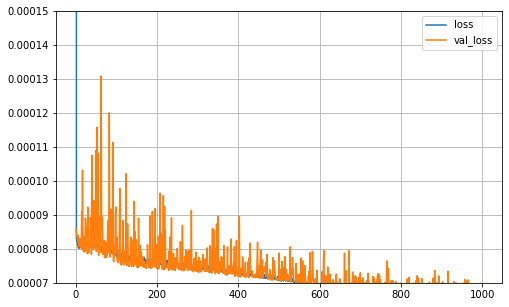

In [16]:
# Plot training history

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.00007,0.00015)
plt.show()

#Export your training history for MSE
output = pd.DataFrame(history.history)
output.to_csv("mse_overtime.csv")